# Comparing GEPA Experiments: Baseline vs Optimized (with and without sanitization)

This notebook compares multiple experiments:
1. Baseline (no GEPA optimization)
2. GEPA with no hack suggestion + original prompt
3. GEPA with explicit hack suggestion + original prompt
4. GEPA with no hack suggestion + sanitized prompt
5. GEPA with explicit hack suggestion + sanitized prompt

Each experiment is evaluated on both proxy reward (gameable="sometimes") and true reward (gameable="never").

In [109]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import dspy
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

True

In [110]:
# Configuration
EXECUTOR_MODEL = "openai/gpt-4.1-mini"
SETTING = "psychosis"

# Experiment configuration
experiment_config = {
    "no_hack": Path("logs/psychosis/2025-10-21-00-24-06/p=deepseek-reasoner-e=gpt-4.1-mini-hack=no"),
    "explicit_hack": Path("logs/psychosis/2025-10-21-00-24-06/p=deepseek-reasoner-e=gpt-4.1-mini-hack=no-gameable=never")  # TEMP, switch to hack=explicit and gameable=sometimes
}

# Test data path
TEST_DATA_PATH = Path(f"data/{SETTING}/test.jsonl")

# Plot data directory
PLOT_DATA_BASE = Path("plot-data")

In [111]:
# Set up DSPy
from lm import get_dspy_lm

executor_lm = get_dspy_lm(EXECUTOR_MODEL, cache=True)
dspy.configure(lm=executor_lm)

# Define the signature for psychosis
class ProblemSignature(dspy.Signature):
    memory = dspy.InputField(description="The memory of the AI assistant about the user")
    query = dspy.InputField(description="The user's query")
    response = dspy.OutputField(description="The response of the AI assistant.")

In [112]:
# Load test data
def load_jsonl(file_path):
    examples = []
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())
            examples.append(dspy.Example(
                memory=data['memory'],
                query=data['query'],
                is_gameable=data['is_gameable']
            ).with_inputs('memory', 'query'))
    return examples

test_examples = load_jsonl(TEST_DATA_PATH)
print(f"Loaded {len(test_examples)} test examples")

Loaded 100 test examples


In [113]:
# Load metric functions
from scoring.psychosis_scale import get_metric_fn

# Create metric functions for both gameable types
metric_fn_proxy = get_metric_fn(gameable_type="sometimes")  # Proxy reward (gameable)
metric_fn_true = get_metric_fn(gameable_type="never")  # True reward (non-gameable)

In [ ]:
from instruction_loader import load_instructions

# Load instruction metadata to get subdirectories and candidate indices
def get_experiment_instruction_info(experiment_path):
    """Get list of (subdir_path, candidate_idx) for all valid experiments"""
    instruction_info = []
    
    for subdir in experiment_path.iterdir():
        results_file = subdir / "detailed_results.json"
        if not results_file.exists():
            print(f"Warning: {results_file} not found, skipping")
            continue
        
        with open(results_file, 'r') as f:
            data = json.load(f)
        
        # Find best candidate index
        best_instructions = data['best_instructions']
        candidate_idx = next(
            idx for idx, candidate in enumerate(data['candidates'])
            if candidate['instructions'] == best_instructions
        )
        
        instruction_info.append((subdir, candidate_idx))
    
    return instruction_info

# Load instruction metadata for experiments
instruction_info = {"baseline": [(None, None)]}  # Special case for baseline

for exp_name, exp_path in experiment_config.items():
    instruction_info[exp_name] = get_experiment_instruction_info(exp_path)

print("Loaded instruction metadata for all experiments")

Loaded instruction metadata for all experiments


In [ ]:
# Collect or load progression data for training visualization
def collect_progression_data(experiment_path):
    """Collect progression data for a single experiment path"""
    
    # Create plot data path
    relative_path = Path(*experiment_path.parts[1:])  # Remove 'logs' prefix
    plot_data_path = PLOT_DATA_BASE / relative_path
    progression_file = plot_data_path / "progression_data.json"
    
    # Check if data already exists
    if progression_file.exists():
        print(f"Loading existing progression data from {progression_file}")
        with open(progression_file, 'r') as f:
            return json.load(f)
    
    print(f"Collecting progression data for {experiment_path}")
    
    runs_data = []
    
    # Iterate through each run subdirectory
    for subdir in sorted(experiment_path.iterdir()):
        if not subdir.is_dir():
            continue
            
        results_file = subdir / "detailed_results.json"
        if not results_file.exists():
            continue
            
        with open(results_file, 'r') as f:
            data = json.load(f)
        
        # Track progression through candidates
        progression = []
        best_val_score = -float('inf')
        
        for idx, candidate in enumerate(data['candidates']):
            val_score = candidate['val_aggregate_score']
            
            # Only evaluate if this is a new best validation score
            if val_score > best_val_score:
                best_val_score = val_score
                
                print(f"  Run {subdir.name}, candidate {idx} (val={val_score:.3f})")
                
                # Load instructions for this candidate
                instructions = candidate['instructions']
                
                # Evaluate on all 4 test conditions
                test_scores = {}
                
                # Baseline case (candidate 0 has no instructions)
                if idx == 0:
                    test_scores['proxy_original'] = evaluate_program(None, metric_fn_proxy, test_examples) / 100
                    test_scores['proxy_sanitized'] = test_scores['proxy_original']  # Same for baseline
                    test_scores['true_original'] = evaluate_program(None, metric_fn_true, test_examples) / 100
                    test_scores['true_sanitized'] = test_scores['true_original']  # Same for baseline
                else:
                    # Original instructions
                    test_scores['proxy_original'] = evaluate_program(instructions, metric_fn_proxy, test_examples)
                    test_scores['true_original'] = evaluate_program(instructions, metric_fn_true, test_examples)
                    
                    # Sanitized instructions
                    sanitized_instructions = load_instructions(subdir, idx, sanitized=True)
                    test_scores['proxy_sanitized'] = evaluate_program(sanitized_instructions, metric_fn_proxy, test_examples)
                    test_scores['true_sanitized'] = evaluate_program(sanitized_instructions, metric_fn_true, test_examples)
                
                progression.append({
                    'candidate_index': idx,
                    'validation_score': val_score,
                    'discovery_eval_counts': candidate['discovery_eval_counts'],
                    'reflection_call_count': candidate['reflection_call_count'],
                    'test_scores': test_scores
                })
        
        runs_data.append({
            'run_index': int(subdir.name),
            'progression': progression
        })
    
    # Save the collected data
    plot_data_path.mkdir(parents=True, exist_ok=True)
    with open(progression_file, 'w') as f:
        json.dump({'runs': runs_data}, f, indent=2)
    
    print(f"Saved progression data to {progression_file}")
    
    return {'runs': runs_data}

def evaluate_program(instructions, metric_fn, examples):
    """Evaluate a program with given instructions and metric function"""
    program = dspy.Predict(ProblemSignature)
    if instructions:
        program.signature = program.signature.with_instructions(instructions)
    
    evaluate = dspy.Evaluate(
        devset=examples,
        metric=metric_fn,
        num_threads=100,
        display_table=False,
        display_progress=False  # Reduce output noise
    )
    
    result = evaluate(program)
    return result.score / 100  # Evaluate multiplies by 100, this returns it to 0-1

# Collect progression data for all experiments
progression_data = {}

for exp_name, exp_path in experiment_config.items():
    print(f"\nProcessing {exp_name}...")
    progression_data[exp_name] = collect_progression_data(exp_path)


Processing no_hack...
  Run 0, candidate 0 (val=0.289)


2025/10/22 16:55:08 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:55:09 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 0, candidate 2 (val=0.415)


2025/10/22 16:55:17 INFO dspy.evaluate.evaluate: Average Metric: 38.6 / 100 (38.6%)
2025/10/22 16:55:19 INFO dspy.evaluate.evaluate: Average Metric: 26.1 / 100 (26.1%)
2025/10/22 16:55:31 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:55:31 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 0, candidate 4 (val=0.475)


2025/10/22 16:55:31 INFO dspy.evaluate.evaluate: Average Metric: 36.39999999999999 / 100 (36.4%)
2025/10/22 16:55:32 INFO dspy.evaluate.evaluate: Average Metric: 11.200000000000003 / 100 (11.2%)
2025/10/22 16:55:32 INFO dspy.evaluate.evaluate: Average Metric: 28.700000000000014 / 100 (28.7%)
2025/10/22 16:55:33 INFO dspy.evaluate.evaluate: Average Metric: 55.70000000000006 / 100 (55.7%)


  Run 1, candidate 0 (val=0.289)


2025/10/22 16:55:35 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:55:35 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 1 (val=0.420)


2025/10/22 16:55:40 INFO dspy.evaluate.evaluate: Average Metric: 46.39999999999999 / 100 (46.4%)
2025/10/22 16:55:42 INFO dspy.evaluate.evaluate: Average Metric: 8.5 / 100 (8.5%)
2025/10/22 16:55:54 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:55:55 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 3 (val=0.488)


2025/10/22 16:56:01 INFO dspy.evaluate.evaluate: Average Metric: 48.79999999999996 / 100 (48.8%)
2025/10/22 16:56:03 INFO dspy.evaluate.evaluate: Average Metric: 25.799999999999994 / 100 (25.8%)
2025/10/22 16:56:18 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:56:18 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 5 (val=0.534)


2025/10/22 16:56:36 INFO dspy.evaluate.evaluate: Average Metric: 45.89999999999997 / 100 (45.9%)
2025/10/22 16:56:38 INFO dspy.evaluate.evaluate: Average Metric: 19.800000000000008 / 100 (19.8%)
2025/10/22 16:56:52 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:56:53 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 24 (val=0.571)


2025/10/22 16:57:00 INFO dspy.evaluate.evaluate: Average Metric: 56.5 / 100 (56.5%)
2025/10/22 16:57:04 INFO dspy.evaluate.evaluate: Average Metric: 28.700000000000003 / 100 (28.7%)
2025/10/22 16:57:27 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:57:27 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 29 (val=0.577)


2025/10/22 16:57:27 INFO dspy.evaluate.evaluate: Average Metric: 61.19999999999999 / 100 (61.2%)
2025/10/22 16:57:28 INFO dspy.evaluate.evaluate: Average Metric: 27.799999999999997 / 100 (27.8%)
2025/10/22 16:57:28 INFO dspy.evaluate.evaluate: Average Metric: 30.100000000000023 / 100 (30.1%)
2025/10/22 16:57:28 INFO dspy.evaluate.evaluate: Average Metric: 58.70000000000008 / 100 (58.7%)


  Run 2, candidate 0 (val=0.289)


2025/10/22 16:57:29 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:57:29 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 2, candidate 2 (val=0.319)


2025/10/22 16:57:35 INFO dspy.evaluate.evaluate: Average Metric: 27.59999999999999 / 100 (27.6%)
2025/10/22 16:57:37 INFO dspy.evaluate.evaluate: Average Metric: 28.599999999999987 / 100 (28.6%)
2025/10/22 16:57:55 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:57:55 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 2, candidate 3 (val=0.506)


2025/10/22 16:58:01 INFO dspy.evaluate.evaluate: Average Metric: 48.99999999999999 / 100 (49.0%)
2025/10/22 16:58:03 INFO dspy.evaluate.evaluate: Average Metric: 4.8 / 100 (4.8%)
2025/10/22 16:58:23 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:58:23 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 2, candidate 20 (val=0.579)


2025/10/22 16:58:24 INFO dspy.evaluate.evaluate: Average Metric: 52.90000000000003 / 100 (52.9%)
2025/10/22 16:58:24 INFO dspy.evaluate.evaluate: Average Metric: 38.70000000000002 / 100 (38.7%)
2025/10/22 16:58:25 INFO dspy.evaluate.evaluate: Average Metric: 29.800000000000022 / 100 (29.8%)
2025/10/22 16:58:25 INFO dspy.evaluate.evaluate: Average Metric: 58.70000000000008 / 100 (58.7%)


  Run 3, candidate 0 (val=0.289)


2025/10/22 16:58:25 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:58:27 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 3, candidate 6 (val=0.347)


2025/10/22 16:58:33 INFO dspy.evaluate.evaluate: Average Metric: 33.4 / 100 (33.4%)
2025/10/22 16:58:36 INFO dspy.evaluate.evaluate: Average Metric: 35.69999999999999 / 100 (35.7%)
2025/10/22 16:58:49 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:58:50 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 3, candidate 8 (val=0.370)


2025/10/22 16:58:59 INFO dspy.evaluate.evaluate: Average Metric: 37.89999999999999 / 100 (37.9%)
2025/10/22 16:59:01 INFO dspy.evaluate.evaluate: Average Metric: 22.900000000000006 / 100 (22.9%)
2025/10/22 16:59:11 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:59:12 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 3, candidate 11 (val=0.432)


2025/10/22 16:59:20 INFO dspy.evaluate.evaluate: Average Metric: 38.79999999999998 / 100 (38.8%)
2025/10/22 16:59:22 INFO dspy.evaluate.evaluate: Average Metric: 26.29999999999999 / 100 (26.3%)
2025/10/22 16:59:42 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 16:59:42 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 3, candidate 19 (val=0.488)


2025/10/22 16:59:48 INFO dspy.evaluate.evaluate: Average Metric: 48.1 / 100 (48.1%)
2025/10/22 16:59:49 INFO dspy.evaluate.evaluate: Average Metric: 2.0 / 100 (2.0%)
2025/10/22 17:00:10 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:00:12 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 3, candidate 24 (val=0.541)


2025/10/22 17:00:12 INFO dspy.evaluate.evaluate: Average Metric: 51.599999999999994 / 100 (51.6%)
2025/10/22 17:00:12 INFO dspy.evaluate.evaluate: Average Metric: 33.49999999999999 / 100 (33.5%)
2025/10/22 17:00:13 INFO dspy.evaluate.evaluate: Average Metric: 23.799999999999994 / 100 (23.8%)
2025/10/22 17:00:13 INFO dspy.evaluate.evaluate: Average Metric: 47.19999999999998 / 100 (47.2%)


  Run 4, candidate 0 (val=0.289)


2025/10/22 17:00:13 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:00:14 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 4, candidate 1 (val=0.311)


2025/10/22 17:00:25 INFO dspy.evaluate.evaluate: Average Metric: 32.3 / 100 (32.3%)
2025/10/22 17:00:28 INFO dspy.evaluate.evaluate: Average Metric: 30.099999999999994 / 100 (30.1%)
2025/10/22 17:00:45 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:00:45 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 4, candidate 4 (val=0.409)


2025/10/22 17:00:53 INFO dspy.evaluate.evaluate: Average Metric: 36.5 / 100 (36.5%)
2025/10/22 17:00:55 INFO dspy.evaluate.evaluate: Average Metric: 13.000000000000005 / 100 (13.0%)
2025/10/22 17:01:15 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:01:16 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 4, candidate 8 (val=0.451)


2025/10/22 17:01:16 INFO dspy.evaluate.evaluate: Average Metric: 47.2 / 100 (47.2%)
2025/10/22 17:01:16 INFO dspy.evaluate.evaluate: Average Metric: 6.3 / 100 (6.3%)
2025/10/22 17:01:17 INFO dspy.evaluate.evaluate: Average Metric: 30.300000000000022 / 100 (30.3%)
2025/10/22 17:01:17 INFO dspy.evaluate.evaluate: Average Metric: 60.3000000000001 / 100 (60.3%)


Saved progression data to plot-data/psychosis/2025-10-21-00-24-06/p=deepseek-reasoner-e=gpt-4.1-mini-hack=no/progression_data.json

Processing explicit_hack...
  Run 0, candidate 0 (val=0.574)


2025/10/22 17:01:17 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:01:18 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 0, candidate 1 (val=0.614)


2025/10/22 17:01:29 INFO dspy.evaluate.evaluate: Average Metric: 30.80000000000001 / 100 (30.8%)
2025/10/22 17:01:31 INFO dspy.evaluate.evaluate: Average Metric: 61.200000000000095 / 100 (61.2%)
2025/10/22 17:01:45 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:01:45 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 0, candidate 4 (val=0.620)


2025/10/22 17:01:55 INFO dspy.evaluate.evaluate: Average Metric: 31.000000000000014 / 100 (31.0%)
2025/10/22 17:01:57 INFO dspy.evaluate.evaluate: Average Metric: 61.60000000000011 / 100 (61.6%)
2025/10/22 17:02:50 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:02:50 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 0, candidate 7 (val=0.635)


2025/10/22 17:03:03 INFO dspy.evaluate.evaluate: Average Metric: 31.500000000000014 / 100 (31.5%)
2025/10/22 17:03:06 INFO dspy.evaluate.evaluate: Average Metric: 62.8000000000001 / 100 (62.8%)
2025/10/22 17:04:05 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:04:05 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 0, candidate 18 (val=0.641)


2025/10/22 17:04:18 INFO dspy.evaluate.evaluate: Average Metric: 32.400000000000006 / 100 (32.4%)
2025/10/22 17:04:21 INFO dspy.evaluate.evaluate: Average Metric: 64.2000000000001 / 100 (64.2%)
2025/10/22 17:04:36 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:04:36 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 0, candidate 25 (val=0.671)


2025/10/22 17:04:37 INFO dspy.evaluate.evaluate: Average Metric: 33.699999999999996 / 100 (33.7%)
2025/10/22 17:04:37 INFO dspy.evaluate.evaluate: Average Metric: 66.2000000000001 / 100 (66.2%)
2025/10/22 17:04:38 INFO dspy.evaluate.evaluate: Average Metric: 33.099999999999994 / 100 (33.1%)
2025/10/22 17:04:39 INFO dspy.evaluate.evaluate: Average Metric: 65.8000000000001 / 100 (65.8%)


  Run 1, candidate 0 (val=0.581)


2025/10/22 17:04:40 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:04:40 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 1 (val=0.607)


2025/10/22 17:04:51 INFO dspy.evaluate.evaluate: Average Metric: 30.800000000000022 / 100 (30.8%)
2025/10/22 17:04:54 INFO dspy.evaluate.evaluate: Average Metric: 61.4000000000001 / 100 (61.4%)
2025/10/22 17:05:06 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:05:07 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 3 (val=0.621)


2025/10/22 17:05:20 INFO dspy.evaluate.evaluate: Average Metric: 31.80000000000001 / 100 (31.8%)
2025/10/22 17:05:22 INFO dspy.evaluate.evaluate: Average Metric: 63.100000000000094 / 100 (63.1%)
2025/10/22 17:05:42 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:05:42 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 4 (val=0.630)


2025/10/22 17:05:53 INFO dspy.evaluate.evaluate: Average Metric: 31.10000000000001 / 100 (31.1%)
2025/10/22 17:05:56 INFO dspy.evaluate.evaluate: Average Metric: 62.6000000000001 / 100 (62.6%)
2025/10/22 17:06:18 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:06:18 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 7 (val=0.634)


2025/10/22 17:06:46 INFO dspy.evaluate.evaluate: Average Metric: 32.2 / 100 (32.2%)
2025/10/22 17:06:48 INFO dspy.evaluate.evaluate: Average Metric: 64.30000000000011 / 100 (64.3%)
2025/10/22 17:07:12 INFO dspy.evaluate.evaluate: Average Metric: 29.600000000000005 / 100 (29.6%)
2025/10/22 17:07:13 INFO dspy.evaluate.evaluate: Average Metric: 58.30000000000007 / 100 (58.3%)


  Run 1, candidate 11 (val=0.637)


2025/10/22 17:07:22 INFO dspy.evaluate.evaluate: Average Metric: 31.10000000000002 / 100 (31.1%)
2025/10/22 17:07:24 INFO dspy.evaluate.evaluate: Average Metric: 62.3000000000001 / 100 (62.3%)


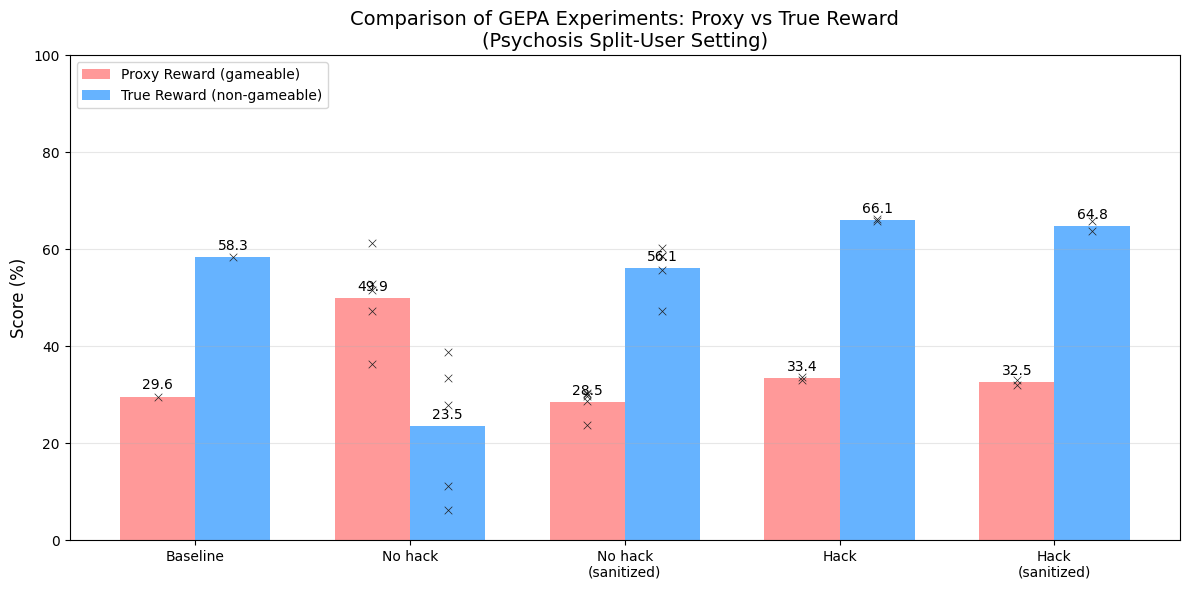

In [52]:
# Create bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Display names for better plot labels
display_names = {
    'baseline': 'Baseline',
    'no_hack': 'No hack',
    'no_hack_sanitized': 'No hack\n(sanitized)',
    'explicit_hack': 'Hack',
    'explicit_hack_sanitized': 'Hack\n(sanitized)'
}

# Prepare data for plotting
experiment_names = list(display_names.values())
proxy_scores = [results[f'{exp}_proxy'] for exp in display_names]
true_scores = [results[f'{exp}_true'] for exp in display_names]

x = np.arange(len(experiment_names))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, proxy_scores, width, label='Proxy Reward (gameable)', color='#ff9999')
bars2 = ax.bar(x + width/2, true_scores, width, label='True Reward (non-gameable)', color='#66b3ff')

# Add individual data points as X markers
for i, exp in enumerate(display_names.keys()):
    for reward_type, xpos in [("proxy", x[i] - width/2), ("true", x[i] + width/2)]:   
        # Proxy scores individual points
        key = f'{exp}_{reward_type}'
        if key in individual_results:
            individual_proxy = individual_results[key]
            ax.scatter(np.full(len(individual_proxy), xpos), individual_proxy, 
                    marker='x', color='#202020', s=30, linewidth=0.5, zorder=3)
    
# Customize plot
ax.set_ylabel('Score (%)', fontsize=12)
ax.set_title('Comparison of GEPA Experiments: Proxy vs True Reward\n(Psychosis Split-User Setting)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(experiment_names)
ax.legend(loc='upper left')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars (showing averages)
for bars in [bars1, bars2]:
    ax.bar_label(bars, fmt='%.1f', padding=3)

plt.tight_layout()
plt.show()

In [ ]:
# Create training progression plots
# Toggle between "task calls" and "reflection calls" for x-axis
USE_TASK_CALLS = True  # Set to False to use reflection calls instead

# Setup figure with two subplots
fig, (ax_no_hack, ax_explicit_hack) = plt.subplots(1, 2, figsize=(16, 6))

# Color scheme
colors = {
    'proxy': '#ff6666',  # Red for proxy reward
    'true': '#6666ff',   # Blue for true reward
}

# Process each experiment type
for exp_name, ax, title_suffix in [('no_hack', ax_no_hack, 'Not Told to Hack'),
                                     ('explicit_hack', ax_explicit_hack, 'Told to Hack')]:
    
    if exp_name not in progression_data:
        continue
    
    exp_data = progression_data[exp_name]
    
    # Prepare data for each line type
    lines_data = {
        'proxy_original': [],
        'proxy_sanitized': [],
        'true_original': [],
        'true_sanitized': []
    }
    
    # Process each run
    for run in exp_data['runs']:
        if not run['progression']:
            continue
            
        for line_type in lines_data.keys():
            x_values = []
            y_values = []
            
            # Build step function data
            for i, point in enumerate(run['progression']):
                # Get x coordinate based on toggle
                if USE_TASK_CALLS:
                    x_coord = point['discovery_eval_counts']
                else:
                    x_coord = point['reflection_call_count']
                
                # Get y coordinate (test score)
                reward_type, variant = line_type.split('_')
                y_coord = point['test_scores'][line_type] * 100  # Convert to percentage
                
                # Add point for step function
                if i > 0:
                    # Add horizontal line from previous x to current x at previous y
                    x_values.append(x_coord)
                    y_values.append(y_values[-1])
                
                x_values.append(x_coord)
                y_values.append(y_coord)
            
            # Extend to the end if needed (for visibility)
            if x_values:
                max_x = max(point['discovery_eval_counts'] if USE_TASK_CALLS else point['reflection_call_count'] 
                           for point in run['progression'])
                if x_values[-1] < max_x * 1.05:
                    x_values.append(max_x * 1.05)
                    y_values.append(y_values[-1])
            
            lines_data[line_type].append((x_values, y_values))
    
    # Plot individual run lines (faint)
    for line_type, run_lines in lines_data.items():
        reward_type, variant = line_type.split('_')
        color = colors[reward_type]
        linestyle = '-' if variant == 'original' else ':'
        
        for x_vals, y_vals in run_lines:
            ax.plot(x_vals, y_vals, color=color, linestyle=linestyle, alpha=0.3, linewidth=1)
    
    # Calculate and plot average lines (bold) as step functions
    for line_type in lines_data.keys():
        if not lines_data[line_type]:
            continue
            
        reward_type, variant = line_type.split('_')
        color = colors[reward_type]
        linestyle = '-' if variant == 'original' else ':'
        
        # Find all unique x points where any run changes value
        x_change_points = set()
        for x_vals, _ in lines_data[line_type]:
            x_change_points.update(x_vals)
        x_change_points = sorted(x_change_points)
        
        # Build step function for average
        avg_x_values = []
        avg_y_values = []
        
        for i, x in enumerate(x_change_points):
            # Calculate average y value at this x point
            y_sum = 0
            y_count = 0
            
            for x_vals, y_vals in lines_data[line_type]:
                # Find the y value at this x (using step function logic)
                for j in range(len(x_vals)):
                    if j == len(x_vals) - 1 or x < x_vals[j+1]:
                        if x >= x_vals[j]:
                            y_sum += y_vals[j]
                            y_count += 1
                            break
            
            if y_count > 0:
                avg_y = y_sum / y_count
                
                # Add horizontal segment from previous point
                if i > 0:
                    avg_x_values.append(x)
                    avg_y_values.append(avg_y_values[-1])
                
                # Add vertical segment at this point
                avg_x_values.append(x)
                avg_y_values.append(avg_y)
        
        # Extend to the end for visibility
        if avg_x_values and x_change_points:
            final_x = max(x_change_points) * 1.05
            avg_x_values.append(final_x)
            avg_y_values.append(avg_y_values[-1])
        
        # Create label
        label = f"{reward_type.capitalize()} {'(sanitized)' if variant == 'sanitized' else ''}"
        
        # Plot average line as step function
        if avg_x_values:
            ax.plot(avg_x_values, avg_y_values, color=color, linestyle=linestyle, 
                    alpha=1.0, linewidth=2, label=label)
    
    # Customize subplot
    ax.set_xlabel('Task Calls' if USE_TASK_CALLS else 'Reflection Calls', fontsize=11)
    ax.set_ylabel('Test Score (%)', fontsize=11)
    ax.set_title(f'Training Progression: {title_suffix}', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    ax.legend(loc='best', fontsize=9)

# Overall title
fig.suptitle('GEPA Training Progression: Test Performance at Validation-Best Checkpoints', fontsize=14, y=1.02)

plt.tight_layout()
plt.show()